In [1]:
from pyrosetta import *
from pyrosetta.rosetta import *
init()
import pyrosetta.rosetta.protocols.rigid as rigid_moves
from pyrosetta.rosetta.core.id import *
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import itertools

Found rosetta database at: /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database; using it....
PyRosetta-4 2017 [Rosetta PyRosetta4.Release.python27.ubuntu 2018.11+release.7c7790f7c7790fbb898f8210b54513b9f9c8a927c3e8d7f 2018-03-14T13:19:04] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.

core.init: Checking for fconfig files in pwd and ./rosetta/flags

core.init: Rosetta version: PyRosetta4.Release.python27.ubuntu r173 2018.11+release.7c7790f 7c7790fbb898f8210b54513b9f9c8a927c3e8d7f http://www.pyrosetta.org 2018-03-14T13:19:04
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=790666914 seed_offset=0 real_seed=790666914
core.init.random: RandomGenerator:i

In [4]:
pose = pyrosetta.rosetta.protocols.recces.pose_setup_turner('g', 'c')
print pose.fold_tree()

FOLD_TREE  JEDGE 1 2 1  C4   C2   END 


In [5]:
print pose.jump(1).get_rotation()

    -0.9886659846906694      0.1490990139497438    -0.01757995320934844
     0.1490824743093656      0.9888221937379476    0.002255000015532804
    0.01771966617705101  -0.0003914211118583588     -0.9998429177726306



In [6]:
pert_mover = rigid_moves.RigidBodyPerturbMover(1, 2, 0.5)

In [ ]:
pmm = PyMOLMover()
pmm.apply(pose)

In [ ]:
pert_mover.apply(pose)
pmm.apply(pose)

In [ ]:
movemap = MoveMap()

In [ ]:
movemap.set_jump(1, True)
movemap.set_bb(True)
movemap.set_chi(True)

In [ ]:
scorefxn = protocols.rna.denovo.get_rna_hires_scorefxn()

In [ ]:
minmover = protocols.minimization_packing.MinMover()
minmover.score_function(scorefxn)
minmover.tolerance(1e-7)
minmover.max_iter(100000)
minmover.movemap(movemap)

In [ ]:
minmover.apply(pose)

In [ ]:
pmm.apply(pose)

In [ ]:
print pert_mover.

In [ ]:
scorefxn(pose)

In [ ]:
pose.jump(1).set_translation(numeric.xyzVector_double_t(1.,1.,1.))

In [ ]:
print core.id.TorsionID(1, BB, 2)

In [ ]:
scorefxn(pose)

In [ ]:
trans_mover = rigid_moves.RigidBodyTransMover(pose, 1)
spin_mover = rigid_moves.RigidBodyDeterministicSpinMover()
spin_mover.rb_jump(1)
spin_mover.angle_magnitude(-1)
pmm.apply(pose)


In [ ]:
trans_mover.step_size(20)
trans_mover.apply(pose)
E_0 = scorefxn(pose)

In [ ]:
pmm.apply(pose)

In [37]:
pose.assign(minimum)
pert_mover.apply(pose)

In [ ]:

spin_mover.spin_axis(numeric.xyzVector_double_t(0,1,0))

In [ ]:
spin_mover.apply(pose)
pmm.apply(pose)

In [7]:
def numpy_hessian(x, h):
        
    x_grad = np.gradient(x, h)
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype = x.dtype)
    
    for k, grad_k in enumerate(x_grad):
        tmp_grad = np.gradient(grad_k, h)
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
            
    return hessian

In [8]:
def tr_energy(pose, scorefxn, i, j, h=0.001):
    
    w = 0.004
    n_pts = int(w/h + 1)
    energy = np.zeros((n_pts,n_pts))
    
    if i == 0: a = numeric.xyzVector_double_t(1,0,0)
    elif i == 1: a = numeric.xyzVector_double_t(0,1,0)
    else: a = numeric.xyzVector_double_t(0,0,1)
            
    if j == 3: b = numeric.xyzVector_double_t(1,0,0)
    elif j == 4: b = numeric.xyzVector_double_t(0,1,0)
    else: b = numeric.xyzVector_double_t(0,0,1)
        
    # Initialize first rigid body mover
    step_i = rigid_moves.RigidBodyTransMover(pose, 1)
    step_i.trans_axis(a)
    step_i.step_size(-w/2)
    
    # Initialize second spin mover
    spin_j = rigid_moves.RigidBodyDeterministicSpinMover()
    spin_j.spin_axis(b)
    spin_j.rot_center(core.conformation.all_atom_center(pose.residue(2)))
    spin_j.angle_magnitude(-w/2./np.pi*180.)
    
    
    step_i.apply(pose)
    spin_j.apply(pose)
    energy[0,0] = scorefxn(pose)
    
    step_i.step_size(h)
    spin_j.angle_magnitude(h/np.pi*180)
    
    for dy in range(1, n_pts):
        
        spin_j.apply(pose)
        energy[0, dy] = scorefxn(pose)
        
    spin_j.angle_magnitude(-(w+h)/np.pi*180)
    spin_j.apply(pose)
    spin_j.angle_magnitude(h/np.pi*180)
       
    for dx in range(1, n_pts):
        
        step_i.apply(pose)
        
        for dy in range(n_pts):
            
            spin_j.apply(pose)
            energy[dx,dy] = scorefxn(pose)
            
        spin_j.angle_magnitude(-(w+h)/np.pi*180)
        spin_j.apply(pose)
        spin_j.angle_magnitude(h/np.pi*180)
    
    return energy



In [9]:
def rr_energy(pose, scorefxn, i, j, h=0.001):
    
    w = 0.004
    n_pts = int(w/h + 1)
    energy = np.zeros((n_pts,n_pts))
    
    if i == 3: 
        
        a = numeric.xyzVector_double_t(1,0,0)
        
        if j == 4: b = numeric.xyzVector_double_t(0,1,0)
        else: b = numeric.xyzVector_double_t(0,0,1)
            
    else: 
        
        a = numeric.xyzVector_double_t(0,1,0)
        b = numeric.xyzVector_double_t(0,0,1)
        
    # Initialize first spin mover
    spin_i = rigid_moves.RigidBodyDeterministicSpinMover()
    spin_i.spin_axis(a)
    spin_i.rot_center(core.conformation.all_atom_center(pose.residue(2)))
    spin_i.angle_magnitude(-w/2./np.pi*180.)
    
    # Initialize second spin mover
    spin_j = rigid_moves.RigidBodyDeterministicSpinMover()
    spin_j.spin_axis(b)
    spin_j.rot_center(core.conformation.all_atom_center(pose.residue(2)))
    spin_j.angle_magnitude(-w/2./np.pi*180.)
    
    spin_i.apply(pose)
    spin_j.apply(pose)
    
    energy[0,0] = scorefxn(pose)
    
    spin_i.angle_magnitude(h/np.pi*180)
    spin_j.angle_magnitude(h/np.pi*180)
    
    for dy in range(1, n_pts):
        
        spin_j.apply(pose)
        energy[0, dy] = scorefxn(pose)
        
    spin_j.angle_magnitude(-(w+h)/np.pi*180)
    spin_j.apply(pose)
    spin_j.angle_magnitude(h/np.pi*180)
       
    for dx in range(1, n_pts):
        
        spin_i.apply(pose)
        
        for dy in range(n_pts):
            
            spin_j.apply(pose)
            energy[dx,dy] = scorefxn(pose)
            
        spin_j.angle_magnitude(-(w+h)/np.pi*180)
        spin_j.apply(pose)
        spin_j.angle_magnitude(h/np.pi*180)
    
        print energy
    
    return energy
        
    
    
        
        

In [10]:
def tt_energy(pose, scorefxn, i, j, h = 0.001):
    
    w = 0.004
    n_pts = int(w/h + 1)
    energy = np.zeros((n_pts,n_pts))
    
    if i == 0: 
        
        a = numeric.xyzVector_double_t(1,0,0)
        
        if j == 1: b = numeric.xyzVector_double_t(0,1,0)
        else: b = numeric.xyzVector_double_t(0,0,1)
            
    else: 
        
        a = numeric.xyzVector_double_t(0,1,0)
        b = numeric.xyzVector_double_t(0,0,1)
    
    # Initialize first rigid body mover
    step_i = rigid_moves.RigidBodyTransMover(pose, 1)
    step_i.trans_axis(a)
    step_i.step_size(-w/2)

    # Initialize second rigid body mover
    step_j = rigid_moves.RigidBodyTransMover(pose, 1)
    step_j.trans_axis(b)
    step_j.step_size(-w/2)
    step_i.apply(pose)
    scorefxn(pose)
    step_j.apply(pose)
    
    energy[0,0] = scorefxn(pose)
    
    step_i.step_size(h)
    step_j.step_size(h)
    
    for dy in range(1,n_pts):
        
        step_j.apply(pose)
        energy[0, dy] = scorefxn(pose)
        
    step_j.step_size(-(w+h))
    step_j.apply(pose)
    
    for dx in range(1, n_pts):
        
        step_i.apply(pose)
        step_j.step_size(h)
        
        for dy in range(n_pts):
            
            step_j.apply(pose)
            energy[dx,dy] = scorefxn(pose)
            print dx, dy
        
        step_j.step_size(-(w+h))
        step_j.apply(pose)
        
    
    return energy
        

In [106]:
# Initialize crap
pose = pyrosetta.rosetta.protocols.recces.pose_setup_turner('u', 'a')
pmm = PyMOLMover()
rna_hires = protocols.rna.denovo.get_rna_hires_scorefxn()
'''
rna_hires.set_weight(core.scoring.ch_bond, 0.)
rna_hires.set_weight(core.scoring.rna_sugar_close, 0.)
rna_hires.set_weight(core.scoring.hbond_lr_bb_sc, 0.)
rna_hires.set_weight(core.scoring.hbond_sr_bb_sc, 0.)
rna_hires.set_weight(core.scoring.hbond_sc, 0.)
rna_hires.set_weight(core.scoring.geom_sol, 0.)
rna_hires.set_weight(core.scoring.atom_pair_constraint, 0.)
rna_hires.set_weight(core.scoring.fa_atr,0.73)
rna_hires.set_weight(core.scoring.fa_rep, 0.10)
rna_hires.set_weight(core.scoring.fa_intra_rep, 0.0071) 
rna_hires.set_weight(core.scoring.lk_nonpolar, 0.25) 
rna_hires.set_weight(core.scoring.fa_elec_rna_phos_phos, 4.54) 
rna_hires.set_weight(core.scoring.rna_torsion, 4.26) 
rna_hires.set_weight(core.scoring.stack_elec, 1.54) 
rna_hires.set_weight(core.scoring.hbond_sc, 2.46)
'''
scorefxn = rna_hires
minimum = Pose()


In [107]:
#only try this stuff if we don't start in a local min (assuming all the other nonsense is valid)
movemap = MoveMap()
movemap.set(core.id.TorsionID(1, JUMP, 1), True) 
movemap.set(core.id.TorsionID(1, JUMP, 2), True)
movemap.set(core.id.TorsionID(1, JUMP, 3), True)
#movemap.set_chi(True)
movemap.set_jump(1, True)
minmover = protocols.minimization_packing.MinMover()
minmover.score_function(scorefxn)
minmover.tolerance(1e-8)
minmover.max_iter(1000000)
minmover.movemap(movemap)
minmover.min_type('linmin_iterated')
minmover.min_options().use_nblist(True)
minmover.min_options().nblist_auto_update(True)
minmover.apply(pose)
minimum.assign(pose)
pmm.apply(minimum)
print scorefxn(minimum)
print pose.jump(1).get_translation()
# Energy of separate bases
far_mover = rigid_moves.RigidBodyTransMover(pose, 1)
far_mover.step_size(20)
far_mover.apply(pose)
E_0 = scorefxn(pose)
print E_0
far_mover.step_size(-20)
far_mover.apply(pose)


-8.33724196608
      6.128689203397231     -0.9445047341370020    -0.03431699555193753


0.0545462617149




In [102]:
# Basic parameters for central diff approximation to hessian
hessian = np.zeros((6,6))


h = 0.001
w = 0.004
#obs = rosetta.protocols.moves.AddPyMOLObserver(pose, True)
n_pts = int(w/h + 1)
ind = int(n_pts/2) # Point at which to approximate hessian
pose.assign(minimum)

for pair in list(itertools.combinations(range(6), 2)):
     
    print pair
    foo = pair[0]
    bar = pair[1]
        
    if foo in [0,1,2] and bar in [0,1,2]:

        energy = tt_energy(pose, scorefxn, foo, bar)
        energy -= E_0
        pose.assign(minimum)
        print energy

    elif foo in [0,1,2] and bar in [3,4,5]:

        energy = tr_energy(pose, scorefxn, foo, bar)
        energy -= E_0
        pose.assign(minimum)

    else:

        energy = rr_energy(pose, scorefxn, foo, bar)
        energy -= E_0
        pose.assign(minimum)
        print energy

    hess = numpy_hessian(energy, h=h)
    
    d2E_dx2 = hess[0,0,:,:]
    d2E_dy2 = hess[1,1,:,:]
    d2E_dxdy = hess[0,1,:,:]
    
    if hessian[foo, foo] == 0: hessian[foo, foo] = d2E_dx2[ind, ind]
    if hessian[bar, bar] == 0: hessian[bar, bar] = d2E_dy2[ind, ind]
    hessian[foo, bar] = d2E_dxdy[ind, ind]
    hessian[bar, foo] = d2E_dxdy[ind, ind]
    
    pose.assign(minimum)
    

(0, 1)


















1 0


1 1


1 2


1 3


1 4






2 0


2 1


2 2


2 3


2 4






3 0


3 1


3 2


3 3


3 4






4 0


4 1


4 2


4 3


4 4


[[-8.39098462 -8.39109945 -8.39117362 -8.3912071  -8.39119986]
 [-8.39127332 -8.39140839 -8.39150282 -8.3915566  -8.3915697 ]
 [-8.39151829 -8.39167355 -8.39178823 -8.36602894 -8.36521956]
 [-8.36835238 -8.36772707 -8.36704734 -8.36631315 -8.36552446]
 [-8.3685314  -8.36792664 -8.36726751 -8.36655395 -8.36578592]]
(0, 2)


















1 0


1 1


1 2


1 3


1 4






2 0


2 1


2 2


2 3


2 4






3 0


3 1


3 2


3 3


3 4






4 0


4 1


4 2


4 3


4 4


[[-8.39112156 -8.39115334 -8.39117362 -8.3911824  -8.39117965]
 [-8.39146748 -8.3914909  -8.39150282 -8.39150323 -8.39149211]
 [-8.36626553 -8.36653093 -8.39178823 -8.39178028 -8.3917608 ]
 [-8.36654599 -8.36680294 -8.36704734 -8.36727918 -8.36749843]
 [-8.36678304 -8.36703155 -8.36726751 -8.3674909  -8.36770171]]
(0, 3)

















































In [103]:
w,v = np.linalg.eigh(hessian)
print w, v
print 0.6163*(scorefxn(minimum) - E_0 + 0.5*np.log(np.linalg.det(hessian)) + np.log(8*np.pi**2) - np.log(6.022e-4))
pmm.apply(minimum)

[-5753.76422561 -3988.35506188  6047.90200634  6255.59756918  6352.22589897
  7503.31089516] [[ -7.15454985e-04  -1.91070614e-03   9.08250506e-01   1.21065813e-01
   -2.18200821e-02   3.99929754e-01]
 [ -1.68280966e-02  -5.64324565e-02  -3.71767363e-01   6.64408716e-01
    3.44490838e-02   6.44744553e-01]
 [  8.36408987e-03   1.68804524e-02   8.44869937e-02   1.90665298e-01
    9.57731659e-01  -1.97240596e-01]
 [ -5.41314724e-03  -4.85652441e-02  -1.69817415e-01  -7.12402289e-01
    2.84696551e-01   6.16607665e-01]
 [ -9.38668114e-01  -3.42053838e-01   1.67811302e-02  -5.43294685e-03
    5.69938944e-03  -3.94681908e-02]
 [  3.44266199e-01  -9.36572136e-01   2.47473715e-02   2.08134605e-03
   -1.61361459e-03  -6.07786961e-02]]
18.1380697422


In [105]:
print scorefxn(minimum)
pmm.apply(minimum)

-8.33724196608


In [95]:
print hessian

[[ 6280.79571217   390.43218551  -115.9460503    338.03734023
    -37.63926856   -50.37499007]
 [  390.43218551  6706.50636686  -137.47998223   454.59803951
   -417.77234199  -518.73745073]
 [ -115.9460503   -137.47998223  6384.45502422  -113.44773255
    163.35010418   141.71714221]
 [  338.03734023   454.59803951  -113.44773255  6704.18321247
   -260.72845799  -489.41103543]
 [  -37.63926856  -417.77234199   163.35010418  -260.72845799
   6977.33677913   601.92951283]
 [  -50.37499007  -518.73745073   141.71714221  -489.41103543
    601.92951283  8352.40315947]]


In [83]:
print d2E_dx2[ind, ind]

923.754085218


In [96]:
print v

[[ 0.83034731 -0.19181948  0.06854348 -0.30039449  0.40910143  0.10690929]
 [-0.4611174  -0.64024991 -0.11794625 -0.10013428  0.49645943  0.32717065]
 [ 0.12813019 -0.0890763  -0.96321618 -0.08364656 -0.17577379 -0.0998473 ]
 [-0.2013566   0.72337263 -0.17332548 -0.35622513  0.43812607  0.29545734]
 [-0.18321592 -0.13938384  0.14623068 -0.85772422 -0.25553602 -0.35303139]
 [-0.08581488  0.05152609 -0.04668972  0.17364428  0.54590706 -0.8121786 ]]


In [52]:
print Vector1([1])

vector1_int[1]


In [53]:
print core.conformation.all_atom_center(pose.residue(2))

      7.061725428519786      -3.976557765784724      -2.481561717597577


In [97]:
def mode_scan_jump(pose, scorefxn, v):
    
    #obs = protocols.moves.AddPyMOLObserver(pose, True)
    
    vals = []
    w = 3.0
    h = 0.05
    
    n_pts = int(w/h + 1)
    
    # Initialize moves for jump DOFs
    x_mover = rigid_moves.RigidBodyTransMover(pose, 1)
    x_mover.trans_axis(numeric.xyzVector_double_t(1,0,0))
    x_mover.step_size(-w/2*v[0])
    
    
    y_mover = rigid_moves.RigidBodyTransMover(pose, 1)
    y_mover.trans_axis(numeric.xyzVector_double_t(0,1,0))
    y_mover.step_size(-w/2*v[1])
    
    z_mover = rigid_moves.RigidBodyTransMover(pose, 1)
    z_mover.trans_axis(numeric.xyzVector_double_t(0,0,1))
    z_mover.step_size(-w/2*v[2])
    #z_mover.step_size(h*v[2])
    
    vx_mover = rigid_moves.RigidBodyDeterministicSpinMover()
    vx_mover.angle_magnitude(-w/2*180./np.pi*v[3])

    vy_mover = rigid_moves.RigidBodyDeterministicSpinMover()
    vy_mover.angle_magnitude(-w/2*180./np.pi*v[4])
    
    vz_mover = rigid_moves.RigidBodyDeterministicSpinMover()
    vz_mover.angle_magnitude(-w/2*180./np.pi*v[5])

    
    x_mover.apply(pose)
    y_mover.apply(pose)
    z_mover.apply(pose)
    
    vx_mover.apply(pose)
    vy_mover.apply(pose)
    vz_mover.apply(pose)
    
    vals.append(scorefxn(pose))
    x_mover.step_size(h*v[0])
    y_mover.step_size(h*v[1])
    z_mover.step_size(h*v[2])
    vx_mover.angle_magnitude(h*180./np.pi*v[3])
    vy_mover.angle_magnitude(h*180./np.pi*v[4])
    vz_mover.angle_magnitude(h*180./np.pi*v[5])
    
    
    for ii in range(1,n_pts):
        
        x_mover.apply(pose)
        y_mover.apply(pose)
        z_mover.apply(pose)

        vx_mover.apply(pose)
        vy_mover.apply(pose)
        vz_mover.apply(pose)

        vals.append(scorefxn(pose))
        
    return vals
        
        
        
        
    

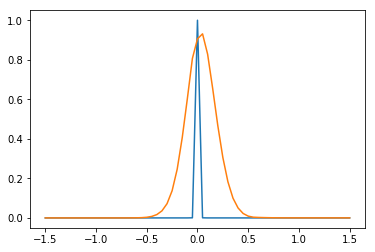

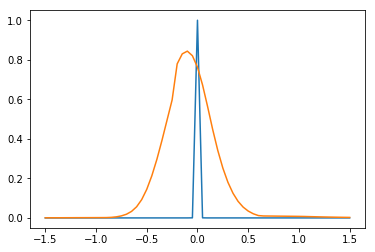

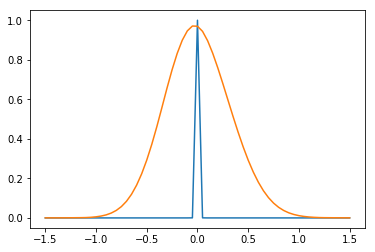

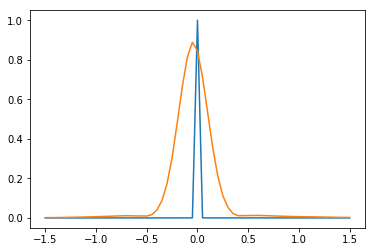

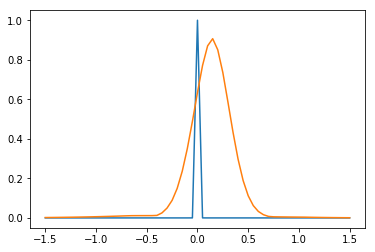

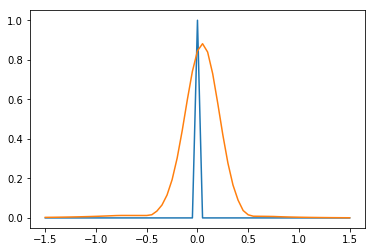

In [98]:
pose.assign(minimum)

obs = pyrosetta.rosetta.protocols.moves.AddPyMOLObserver(pose, True)

Z = 1
for ii in range(6):
    
    #if w[ii] < 0: continue
    sig = 3.0
    h = 0.05
    pose.assign(minimum)
    
    vals = mode_scan_jump(pose, scorefxn, v[:,ii])
    xx = np.arange(-sig/2.,sig/2.+h,h)
    plt.figure()
    plt.plot(xx, np.exp(-0.5*w[ii]*xx**2))
    plt.plot(xx, np.exp(-(np.array(vals)-scorefxn(minimum))))
    Z *= np.trapz(np.exp(-(np.array(vals)-scorefxn(minimum)+E_0)), dx=h)
    pose.assign(minimum)


In [99]:
0.6163*(-np.log(Z) + np.log(8*np.pi**2) - np.log(6.022e-4) + scorefxn(minimum) - E_0)

5.4087979129720196

In [87]:
print -0.6163*np.log(Z)
print scorefxn(minimum)

3.65069422664
-11.9977358691


In [27]:
0.6163*0.5*np.log(np.linalg.det(hessian))
print Z

0.000682438948136


In [28]:
matt_guess = lambda E: 2*(2*np.pi)**((len(w)-1)/2)*(2*(E))**(len(w)/2-1)/scipy.misc.factorial2(len(w)-2)/np.sqrt(np.linalg.det(hessian))

In [29]:
x = np.linspace(-100,100,1001)

In [30]:
y = np.zeros_like(x)
for i, xx in enumerate(x):
    if xx < 0: y[i] = 0
    else: y[i] = matt_guess(xx)
        
plt.plot(x + scorefxn(minimum), 16*np.pi*np.pi*y*np.exp(-x))
plt.plot

AttributeError: 'module' object has no attribute 'misc'

In [31]:
import scipy.special
print y

[ 0.  0.  0. ...,  0.  0.  0.]


In [32]:
print scorefxn(minimum)

-8.91378309429


In [33]:
print -scipy.special.logsumexp(-x, b=y) + np.log(8*np.pi**2) - np.log(6.022e-4) - E_0 + scorefxn(minimum) + np.log(16*np.pi**2)

inf


In [186]:
print -np.log(Z)

7.27380385136


In [183]:
-0.6163*np.log(10*np.exp(-6/0.6163))

4.5809168071877693

In [184]:
print E_0

0.698379728653


In [189]:
print E_0

0.698379728653


In [192]:
print scorefxn(minimum)

-8.64163896161


In [298]:
print v

[[-0.02968234 -0.20941739  0.56418403  0.78540084  0.13897494 -0.02812782]
 [-0.31551042  0.18967668  0.7642461  -0.49478443 -0.11772898 -0.14741808]
 [-0.05413707  0.94176139 -0.0612884   0.3106421  -0.09110477  0.03999754]
 [ 0.88303079  0.05454069  0.2278488  -0.05553989 -0.37173367 -0.15522973]
 [-0.2867751  -0.16839274 -0.05866878  0.15301674 -0.88385144  0.28522693]
 [ 0.18616654  0.04383829  0.19624198 -0.12384092  0.19785468  0.93296638]]


In [245]:
print 1./np.sqrt(w)

[        nan         nan  0.36639025  0.2239356   0.06110476  0.05005549]


/home/maa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [265]:
print xx

[ -1.50000000e+00  -1.47000000e+00  -1.44000000e+00  -1.41000000e+00
  -1.38000000e+00  -1.35000000e+00  -1.32000000e+00  -1.29000000e+00
  -1.26000000e+00  -1.23000000e+00  -1.20000000e+00  -1.17000000e+00
  -1.14000000e+00  -1.11000000e+00  -1.08000000e+00  -1.05000000e+00
  -1.02000000e+00  -9.90000000e-01  -9.60000000e-01  -9.30000000e-01
  -9.00000000e-01  -8.70000000e-01  -8.40000000e-01  -8.10000000e-01
  -7.80000000e-01  -7.50000000e-01  -7.20000000e-01  -6.90000000e-01
  -6.60000000e-01  -6.30000000e-01  -6.00000000e-01  -5.70000000e-01
  -5.40000000e-01  -5.10000000e-01  -4.80000000e-01  -4.50000000e-01
  -4.20000000e-01  -3.90000000e-01  -3.60000000e-01  -3.30000000e-01
  -3.00000000e-01  -2.70000000e-01  -2.40000000e-01  -2.10000000e-01
  -1.80000000e-01  -1.50000000e-01  -1.20000000e-01  -9.00000000e-02
  -6.00000000e-02  -3.00000000e-02   1.33226763e-15   3.00000000e-02
   6.00000000e-02   9.00000000e-02   1.20000000e-01   1.50000000e-01
   1.80000000e-01   2.10000000e-01

In [269]:
print np.arange(-1.5,1.520,0.0200)

[ -1.50000000e+00  -1.48000000e+00  -1.46000000e+00  -1.44000000e+00
  -1.42000000e+00  -1.40000000e+00  -1.38000000e+00  -1.36000000e+00
  -1.34000000e+00  -1.32000000e+00  -1.30000000e+00  -1.28000000e+00
  -1.26000000e+00  -1.24000000e+00  -1.22000000e+00  -1.20000000e+00
  -1.18000000e+00  -1.16000000e+00  -1.14000000e+00  -1.12000000e+00
  -1.10000000e+00  -1.08000000e+00  -1.06000000e+00  -1.04000000e+00
  -1.02000000e+00  -1.00000000e+00  -9.80000000e-01  -9.60000000e-01
  -9.40000000e-01  -9.20000000e-01  -9.00000000e-01  -8.80000000e-01
  -8.60000000e-01  -8.40000000e-01  -8.20000000e-01  -8.00000000e-01
  -7.80000000e-01  -7.60000000e-01  -7.40000000e-01  -7.20000000e-01
  -7.00000000e-01  -6.80000000e-01  -6.60000000e-01  -6.40000000e-01
  -6.20000000e-01  -6.00000000e-01  -5.80000000e-01  -5.60000000e-01
  -5.40000000e-01  -5.20000000e-01  -5.00000000e-01  -4.80000000e-01
  -4.60000000e-01  -4.40000000e-01  -4.20000000e-01  -4.00000000e-01
  -3.80000000e-01  -3.60000000e-01

In [277]:
print E_0

0.698379728653


In [34]:
pmm.apply(minimum)